In [1]:
# required modules (skip if already installed)
if False:
    !pip install pyroaring
    !pip install pyfim 
    # if previous does not work, try: !conda install -c conda-forge pyfim
    !pip install lightgbm
    !pip install fairlearn

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# gloabl imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# local imports
sys.path.append('../src/') # local path
import dd

# general settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=10)
plt.rc('legend', fontsize=10)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [3]:
# read folkstable data
census = pd.read_pickle('../data/ACSIncome.pkl') 
states = list(census['STATE'].unique())
# change to True to binarize RAC1P
if False: 
    census["RAC1P"][census["RAC1P"]!='White alone'] = 'Not White alone'

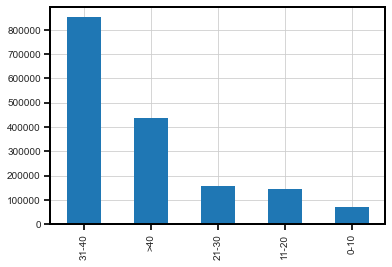

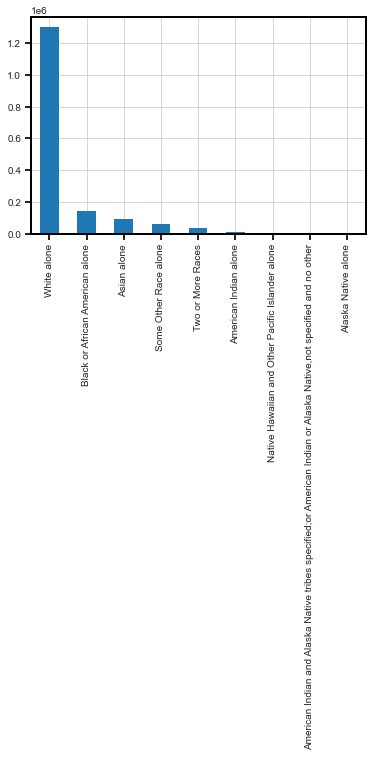

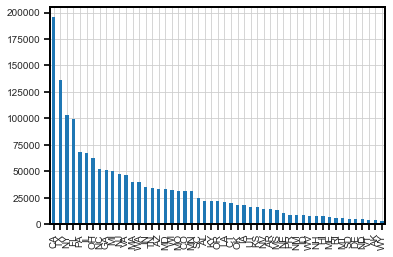

In [4]:
# distributions
census["WKHPgroup"].value_counts().plot(kind='bar')
plt.show()
census["RAC1P"].value_counts().plot(kind='bar')
plt.show()
census["STATE"].value_counts().plot(kind='bar')
plt.show()

In [5]:
census

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,WKHPgroup,AGEPgroup,POBPgroup,OCCPgroup
0,18,Employee of a private for-profit company orbus...,"Some college, but less than 1 year",Never married or under 15 years old,4720.0,13,21.0,Female,Black or African American alone,AL,False,11-20,16-30,US,SAL
1,53,Federal government employee,GED or alternative credential,Never married or under 15 years old,3605.0,18,40.0,Male,White alone,AL,False,31-40,51-60,US,HLS
2,41,Employee of a private for-profit company orbus...,Regular high school diploma,Never married or under 15 years old,7330.0,1,40.0,Male,White alone,AL,False,31-40,31-40,US,RPR
3,18,Self-employed in own not incorporated business...,"Some college, but less than 1 year",Never married or under 15 years old,2722.0,1,2.0,Female,White alone,AL,False,0-10,16-30,US,ENT
4,21,Federal government employee,"1 or more years of college credit, no degree",Never married or under 15 years old,3870.0,12,50.0,Male,White alone,AL,False,>40,16-30,US,PRT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664495,39,Self-employed in own not incorporated business...,Regular high school diploma,Never married or under 15 years old,6260.0,72,20.0,Male,White alone,PR,False,11-20,31-40,US,CON
1664496,38,Self-employed in own not incorporated business...,Grade 11,Never married or under 15 years old,4251.0,72,32.0,Male,Some Other Race alone,PR,False,31-40,31-40,US,CLN
1664497,37,Employee of a private for-profit company orbus...,"1 or more years of college credit, no degree",Divorced,7750.0,17,40.0,Female,Two or More Races,PR,False,31-40,31-40,US,PRD
1664498,47,Employee of a private for-profit company orbus...,Regular high school diploma,Married,8990.0,72,40.0,Male,Some Other Race alone,PR,False,31-40,41-50,US,PRD


In [6]:
# predictive attributes (for models)
pred_atts = ['WKHP', 'RAC1P', 'STATE']
pred_all = pred_atts + ['class']
# discretized attributes (for DD)
disc_atts = ['WKHPgroup', 'RAC1P', 'STATE']
disc_all = disc_atts + ['class']
# encode categorical values
df, encoders = dd.encode(census)
# link census to df
census['STATE2'] = df['STATE'].copy(deep=True)
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,WKHPgroup,AGEPgroup,POBPgroup,OCCPgroup
0,1.0,0.0,23.0,2.0,296.0,10.0,20.0,0.0,4.0,1.0,0.0,1.0,0.0,5.0,22.0
1,36.0,2.0,5.0,2.0,225.0,14.0,39.0,1.0,8.0,1.0,0.0,3.0,3.0,5.0,12.0
2,24.0,0.0,22.0,2.0,421.0,0.0,39.0,1.0,8.0,1.0,0.0,3.0,1.0,5.0,21.0
3,1.0,5.0,23.0,2.0,161.0,0.0,1.0,0.0,8.0,1.0,0.0,0.0,0.0,5.0,8.0
4,4.0,2.0,0.0,2.0,246.0,9.0,49.0,1.0,8.0,1.0,0.0,4.0,0.0,5.0,20.0


In [7]:
# 0 = negative, 1 = positive
encoders['class'].classes_

array([False,  True])

In [8]:
# pretty printing long labels
pretty_rac1p = ['Alaska', 'Indian', 'Alaska-Indian', 'Asian', 'Black', 'Hawaiian', 'Other', 'Two+', 'White']
rac1p_2_pretty = { encoders['RAC1P'].classes_[i]:pretty_rac1p[i] for i in range(len(pretty_rac1p)) }
rac1p_2_pretty

{'Alaska Native alone': 'Alaska',
 'American Indian alone': 'Indian',
 'American Indian and Alaska Native tribes specified;or American Indian or Alaska Native,not specified and no other': 'Alaska-Indian',
 'Asian alone': 'Asian',
 'Black or African American alone': 'Black',
 'Native Hawaiian and Other Pacific Islander alone': 'Hawaiian',
 'Some Other Race alone': 'Other',
 'Two or More Races': 'Two+',
 'White alone': 'White'}

In [9]:
# split train test
X = df[pred_atts]
y = df['class'].astype(int)
X_train, X_test, y_train, y_test, census_train, census_test = train_test_split(X, y, census, test_size=0.33, random_state=42)

In [10]:
# training model and make predictions - replace with your favorite classifier
import lightgbm as lgb

clf = lgb.LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)
# add predicted class in the adult_test (decoding back)
y_pred_b = clf.predict(X_test)
census_test['pred_b'] = encoders['class'].inverse_transform(y_pred_b)
# add predicted score in the adult_test
census_test['score_b'] = clf.predict_proba(X_test)[:,1]
census_test[disc_all].head()

,WKHPgroup,RAC1P,STATE,class
517717,>40,White alone,IL,False
319156,31-40,Black or African American alone,CT,False
507501,31-40,White alone,IL,True
537835,>40,White alone,IL,True
305930,31-40,White alone,CT,True


In [11]:
'''
     contingency table for separation
          protected                                   unprotected
     ========= pred.bad  ==  pred.good  ===   ====  pred.bad  ==  pred.good  === 
     true.bad    TPp          FNp      Pp()           TPu           FNu      Pu()
     true.good   FPp          TNp      Np()           FPu           TNu      Nu()
     ==========   a     =====  b  ===  n1()   ====     c    ====     d  ===  n2()
'''
# Accuracy
def acc(ctg):
    return (ctg.TPp+ctg.TPu+ctg.TNp+ctg.TNu)/ctg.n()

# Equality of opportuniy - FairLearn version is
# P(pred.good|true.good) - P(pred.good|protected,true.good)
def eop_mean(ctg, disc):
    # at least 20 protected and some protected/unprotected negatives
    if ctg.a < 20 or ctg.Np()==0 or ctg.Nu()==0:
        return None
    # compute P(pred.good|true.good)
    trueGood = len(disc.itDB.cover(list(ctg.ctx)+[disc.trueGood]))
    predtrueGood =  len(disc.itDB.cover(list(ctg.ctx)+[disc.trueGood, disc.predGood]))
    #print(predtrueGood/trueGood)
    # end
    return predtrueGood/trueGood - ctg.tnrp()

# To compute P(pred.good|true.good) we need the dd.DD object
metric_b = lambda ctg: eop_mean(ctg, disc_b)

In [12]:
# discrimination in overall test set
disc_b = dd.DD(census_test[disc_all+['pred_b']], unprotectedItem='RAC1P=White alone', 
               predBadItem='pred_b=False', trueBadItem='class=False',) 

In [13]:
# all protected vs unprotected
ctg = disc_b.ctg_any()
disc_b.print(ctg)
print("Metric = {:f}".format(metric_b(ctg)))
print("ACC = {:f}".format(acc(ctg)))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P!=White alone                               RAC1P=White alone
           |pred_b=False|pred_b=True|                      |pred_b=False|pred_b=True|      
class=False|       76116|       9333| 85449     class=False|      212358|      49139|261497
class=True |       21672|      13764| 35436     class=True |       84605|      82298|166903
           |       97788|      23097|120885                |      131437|     296963|428400
Metric = 0.086339
ACC = 0.700066


In [14]:
# each protected
for ctg in disc_b.ctg_global():
    disc_b.print(ctg)
    print("Metric = {:f}".format(metric_b(ctg)))
# and for the unprotected, as fairlearn also consider it
print('-----\nUnprotected')
print("Metric = {:f}".format(metric_b(ctg)+ctg.tnrp()-ctg.tnru()))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Black or African American alone           RAC1P=White alone
           |pred_b=False|pred_b=True|                      |pred_b=False|pred_b=True|      
class=False|       35416|       1152| 36568     class=False|      212358|      49139|261497
class=True |       10405|       1546| 11951     class=True |       84605|      82298|166903
           |       45821|       2698| 48519                |      131437|     296963|428400
Metric = 0.345396
-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Two or More Races                         RAC1P=White alone
           |pred_b=False|pred_b=True|                      |pred_b=False|pred_b=True|      
class=False|        8809|        911|  9720     class=False|      212358|      49139|261497
class=True |        2752|       1368|  4120     class=True |       84605|      82298|166903
           |       11561|       2279| 13840                |      131437|     296963|428400
Metric = 0.142719


In [15]:
# check with the Fairlearn metrics (see decoding of RAC1P for the order)
from fairlearn.reductions import TruePositiveRateParity # EOP is TPR given the coding of classes 
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import true_positive_rate

summary_b = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_b,
                          sensitive_features=X_test['RAC1P'])
summary_b.overall-summary_b.by_group

RAC1P
0.0    0.416787
1.0    0.393125
2.0    0.474758
3.0   -0.274281
4.0    0.345396
5.0    0.312702
6.0    0.468325
7.0    0.142719
8.0   -0.018331
Name: true_positive_rate, dtype: object

In [16]:
# Fairlearn algorithms and utils (https://github.com/fairlearn/fairlearn)
from fairlearn.postprocessing import ThresholdOptimizer

# fairness by post-processing
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_positive_rate_parity", prefit=True, predict_method='predict')
#X_train = X_train.fillna(0) # fairlearn does not manage missing values
#X_test = X_test.fillna(0) # fairlearn does not manage missing values
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['RAC1P'])
# fair-corrected predictions 
y_pred_a = postprocess_est.predict(X_test, sensitive_features=X_test['RAC1P'], random_state=42).astype(int)
census_test['pred_a'] = encoders['class'].inverse_transform(y_pred_a)

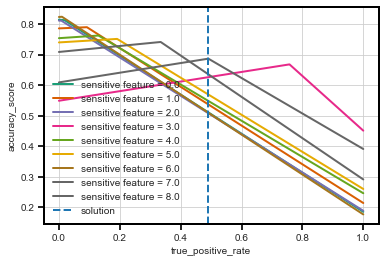

In [17]:
from fairlearn.postprocessing import plot_threshold_optimizer

plot_threshold_optimizer(postprocess_est)

In [18]:
# To compute P(pred.good|true.good) we need the dd.DD object
metric_a = lambda ctg: eop_mean(ctg, disc_a)

# discrimination in overall test set after correction
# DD(filename or dataframe, unprotected item, negative decision, negative truth)
disc_a = dd.DD(census_test[disc_all+['pred_a']], unprotectedItem='RAC1P=White alone', 
               predBadItem='pred_a=False', trueBadItem='class=False', 
               codes=disc_b.codes) # extends the coding of items as disc_b 

In [19]:
# all protected vs unprotected
ctg = disc_a.ctg_any()
disc_a.print(ctg)
print("Metric = {:f}".format(metric_a(ctg)))
print("ACC = {:f}".format(acc(ctg)))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P!=White alone                               RAC1P=White alone
           |pred_a=False|pred_a=True|                      |pred_a=False|pred_a=True|      
class=False|       51894|      33555| 85449     class=False|      212436|      49061|261497
class=True |       18244|      17192| 35436     class=True |       84717|      82186|166903
           |       70138|      50747|120885                |      131247|     297153|428400
Metric = 0.005990
ACC = 0.662148


In [20]:
# each protected vs unprotected
for ctg in disc_a.ctg_global():
    disc_a.print(ctg)
    print("Metric = {:f}".format(metric_a(ctg)))
# and for the unprotected, as fairlearn also consider it
print('-----\nUnprotected')
print("Metric = {:f}".format(metric_a(ctg)+ctg.tnrp()-ctg.tnru()))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Black or African American alone           RAC1P=White alone
           |pred_a=False|pred_a=True|                      |pred_a=False|pred_a=True|      
class=False|       20893|      15675| 36568     class=False|      212436|      49061|261497
class=True |        6126|       5825| 11951     class=True |       84717|      82186|166903
           |       27019|      21500| 48519                |      131247|     297153|428400
Metric = 0.003739
-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Two or More Races                         RAC1P=White alone
           |pred_a=False|pred_a=True|                      |pred_a=False|pred_a=True|      
class=False|        6740|       2980|  9720     class=False|      212436|      49061|261497
class=True |        2137|       1983|  4120     class=True |       84717|      82186|166903
           |        8877|       4963| 13840                |      131247|     297153|428400
Metric = 0.009835


In [21]:
# check with the Fairlearn metrics
summary_a = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_a,
                          sensitive_features=X_test['RAC1P'])
summary_a.overall-summary_a.by_group

RAC1P
0.0   -0.001608
1.0    0.029695
2.0    0.017462
3.0    0.006149
4.0    0.003739
5.0    0.048458
6.0   -0.000411
7.0    0.009835
8.0   -0.001272
Name: true_positive_rate, dtype: object

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


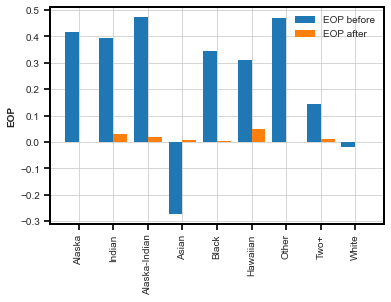

In [22]:
X_axis = np.arange(len(pretty_rac1p))
plt.bar(X_axis - 0.2, summary_b.overall-summary_b.by_group, 0.4, label='EOP before')
plt.bar(X_axis + 0.2, summary_a.overall-summary_a.by_group, 0.4, label='EOP after')
plt.xticks(X_axis, pretty_rac1p)
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("EOP", fontweight="bold")
plt.savefig('fig0.pdf', bbox_inches='tight', dpi=400)
plt.show()

In [23]:
# Fairlearn fails if there is a sensitive group without instances in a control group, e.g., no Other race in a STATE
if False:
    summary_ac = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_a,
                          sensitive_features=X_test['RAC1P'],
                          control_features=X_test['STATE'])

In [35]:
def data_plot(disc_b, metric_b, disc_a, metric_a, unpr=False):
    acs = []
    xs = []
    ys = []
    descs = []
    for s in census['STATE'].unique():
        first = True
        for ctg_b in disc_b.ctg_global(['STATE='+s]):
            x = metric_b(ctg_b)
            # relativize ctg_b to disc_a
            ctg_a = disc_a.ctg_rel(ctg_b) 
            y = metric_a(ctg_a)
            if x is None or y is None:
                continue
            d = disc_b.ctg_info(ctg_b)
            if first:
                # unprotected dot
                x1 = metric_b(ctg_b)+ctg_b.tnrp()-ctg_b.tnru()
                y1 = metric_a(ctg_a)+ctg_a.tnrp()-ctg_a.tnru()
                # accuracy at State level
                ctg_b.protected = -1
                ctg_b = disc_b.ctg_rel(ctg_b) 
                ctg_a.protected = -1
                ctg_a = disc_a.ctg_rel(ctg_a)
                acc_diff = acc(ctg_b)-acc(ctg_a)
                # add unprotected
                if unpr:
                    xs.append(x1)
                    ys.append(y1)
                    descs.append((s, 'unprotected'))
                    acs.append(acc_diff)
                    #print(x1, y1, acc_diff)
                first = False
            xs.append(x)
            ys.append(y)
            descs.append(d)   
            acs.append(acc_diff)
    return xs, ys, descs, acs

xs, ys, descs, acs = data_plot(disc_b, metric_b, disc_a, metric_a)

In [27]:
# development only
if False:
    for i in range(len(xs)):
        if acs[i]>0.07:
            print(i, xs[i], ys[i], ys[i]-xs[i], acs[i], descs[i])

C:\Users\ruggieri\AppData\Local\Temp\ipykernel_19000\2094188436.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


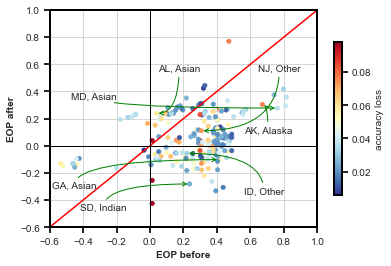

In [36]:
plt.scatter(xs, ys, c =acs, linewidths = .5, marker ="o", cmap="RdYlBu_r", s=20)
plt.xlabel("EOP before", fontweight="bold")
plt.ylabel("EOP after", fontweight="bold")
plt.xlim([-.6, 1])
plt.ylim([-.6, 1])
plt.axline((0, 0), (1, 1), linewidth=1.5, color='r')
plt.axline((0, 0), (0, 1), linewidth=1, color='black')
plt.axline((0, 0), (1, 0), linewidth=1, color='black')
arrow_properties = dict(color='green', arrowstyle="->", connectionstyle="angle3,angleA=90,angleB=0")
id = 2 # 2 0.06819594678602509 0.29230386671639935 0.22410791993037427 ('STATE=AL', 'RAC1P=Asian alone')
plt.annotate("AL, Asian", xy=(xs[id], ys[id]), xycoords='data', xytext=(0.3, 0.6), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 121 # 121 0.8698534098151689 0.3458799963580079 -0.523973413457161 ('STATE=NJ', 'RAC1P=Some Other Race alone')
plt.annotate("NJ, Other", xy=(xs[id], ys[id]), xycoords='data', xytext=(0.9, 0.6), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 50 # 50 0.42983565107458915 -0.4400899002668914 -0.8699255513414805 ('STATE=ID', 'RAC1P=Some Other Race alone')
plt.annotate("ID, Other", xy=(xs[id], ys[id]), xycoords='data', xytext=(0.8, -0.3), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 163 # 163 0.0 -0.5180231240081614 -0.5180231240081614 ('STATE=SD', 'RAC1P=American Indian alone')
plt.annotate("SD, Indian", xy=(xs[id], ys[id]), xycoords='data', xytext=(-0.14, -0.42), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 80 # 80 -0.1890491901156537 0.21018338849228213 0.3992325786079358 ('STATE=MD', 'RAC1P=Asian alone')
plt.annotate("MD, Asian", xy=(xs[id], ys[id]), xycoords='data', xytext=(-0.2, 0.4), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 42 # 42 -0.554163655808307 -0.13408966095326186 0.4200739948550451 ('STATE=GA', 'RAC1P=Asian alone')
plt.annotate("GA, Asian", xy=(xs[id], ys[id]), xycoords='data', xytext=(-0.32, -0.26), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 7 # 7 0.7177777777777777 0.3356349206349207 -0.38214285714285706 0.08146639511201637 ('STATE=AK', 'RAC1P=Alaska Native alone')
plt.annotate("AK, Alaska", xy=(xs[id], ys[id]), xycoords='data', xytext=(0.85, 0.15), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)
plt.savefig('fig1.pdf', bbox_inches='tight', dpi=400)
plt.show()

In [37]:
# Table with distributions of RAC1P by STATE in the training set
ct = pd.crosstab(X_train['STATE'], X_train['RAC1P'])
state_tot = ct.sum(axis=1)
ct = ct.div(ct.sum(axis=1), axis=0)
ct 

RAC1P,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
STATE,,,,,,,,,
0.0,0.213345,0.008500,0.009775,0.057799,0.018700,0.007650,0.011475,0.073523,0.599235
1.0,0.000067,0.003403,0.000667,0.012276,0.196224,0.000133,0.008874,0.012210,0.766146
2.0,0.000000,0.005667,0.000962,0.014328,0.101155,0.001925,0.019033,0.020210,0.836719
3.0,0.000134,0.046286,0.003361,0.036338,0.040819,0.001837,0.051528,0.031499,0.788198
4.0,0.000038,0.006550,0.002181,0.167300,0.043846,0.003081,0.116652,0.041512,0.618841
5.0,0.000189,0.006434,0.002129,0.031793,0.026163,0.001419,0.025264,0.027298,0.879311
6.0,0.000000,0.001725,0.000750,0.045083,0.077189,0.000300,0.034206,0.021229,0.819518
7.0,0.000000,0.004069,0.000939,0.036620,0.164945,0.000626,0.014710,0.016275,0.761815
8.0,0.000045,0.001947,0.000604,0.029765,0.117323,0.000694,0.027908,0.021916,0.799798


D:\FILES\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
D:\FILES\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\FILES\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
D:\FILES\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
D

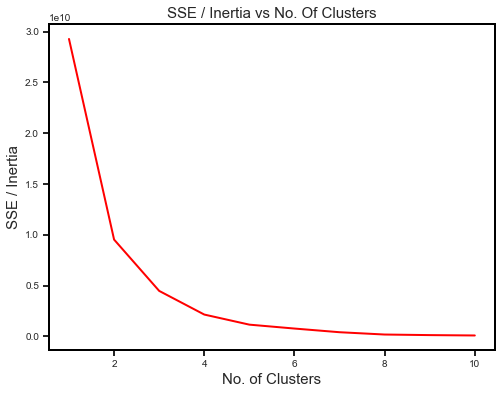

In [43]:
# Cluster Table of distributions
from sklearn.cluster import KMeans

def drawSSEPlot(df, column_indices, ret_clus=5, n_clusters=8, max_iter=300, tol=1e-04, init='k-means++', n_init=10, algorithm='auto'):
    inertia_values = []    
    for i in range(1, n_clusters+1):
        km = KMeans(n_clusters=i, max_iter=max_iter, tol=tol, init=init, n_init=n_init, random_state=42, algorithm=algorithm)
        km.fit_predict(df.iloc[:, column_indices])
        inertia_values.append(km.inertia_)
        if i == ret_clus:
            ret = km
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(range(1, n_clusters+1), inertia_values, color='red')
    plt.xlabel('No. of Clusters', fontsize=15)
    plt.ylabel('SSE / Inertia', fontsize=15)
    plt.title('SSE / Inertia vs No. Of Clusters', fontsize=15)
    plt.grid()
    plt.show()
    return ret

# select final number of clusters based on SSE plot
n_clusters = 6
km = drawSSEPlot(ct, range(len(ct.columns)), n_clusters=10, ret_clus=n_clusters)

In [44]:
# assign cluster to STATE
ct['cluster'] = km.labels_
ct['tot'] = state_tot
ct.sort_values(by=['cluster'])
# instances by cluster
ct[['cluster','tot']].groupby(['cluster']).sum(['tot'])

RAC1P,tot
cluster,
0,69135
1,226212
2,297800
3,131142
4,161539
5,229387


In [45]:
# add cluster to train and test instances
X_train_c = pd.merge(X_train, ct['cluster'], left_on='STATE', right_index=True)
X_test_c = pd.merge(X_test, ct['cluster'], left_on='STATE', right_index=True)
census_test_c = pd.merge(census_test, ct['cluster'], left_on='STATE2', right_index=True)
census_test_c['pred_c'] = 1

In [46]:
# cluster specific ThresholdOptimizer post-processing
for i in range(n_clusters):
    sub = X_train_c['cluster']==i
    postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_positive_rate_parity", prefit=True, predict_method='predict')
    postprocess_est.fit(X_train.loc[sub, pred_atts], y_train[sub], sensitive_features=X_train.loc[sub, 'RAC1P'])
    sub = X_test_c['cluster']==i
    y_pred_s = postprocess_est.predict(X_test_c.loc[sub, pred_atts], sensitive_features=X_test_c.loc[sub, 'RAC1P'], random_state=42).astype(int)
    sub = census_test_c['cluster']==i
    census_test_c.loc[sub, 'pred_c'] = encoders['class'].inverse_transform(y_pred_s)

In [47]:
census_test_c

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,...,WKHPgroup,AGEPgroup,POBPgroup,OCCPgroup,STATE2,pred_b,score_b,pred_a,cluster,pred_c
517717,28,Employee of a private for-profit company orbus...,"Some college, but less than 1 year",Never married or under 15 years old,4700.0,37,50.0,Female,White alone,IL,...,>40,16-30,US,SAL,13.0,True,0.687813,True,2,True
507501,23,Employee of a private for-profit company orbus...,Bachelor's degree,Never married or under 15 years old,1430.0,36,40.0,Male,White alone,IL,...,31-40,16-30,US,ENG,13.0,False,0.428998,False,2,False
537835,33,Employee of a private for-profit company orbus...,Bachelor's degree,Married,4710.0,17,50.0,Female,White alone,IL,...,>40,31-40,US,SAL,13.0,True,0.687813,True,2,True
539525,54,Employee of a private for-profit company orbus...,Bachelor's degree,Divorced,1021.0,13,40.0,Male,White alone,IL,...,31-40,51-60,US,CMM,13.0,False,0.428998,False,2,False
554172,62,Employee of a private for-profit company orbus...,Professional degree beyond a bachelor's degree,Married,4760.0,138,44.0,Male,White alone,IL,...,>40,>60,Europe,SAL,13.0,True,0.566829,True,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619013,25,Employee of a private for-profit company orbus...,Regular high school diploma,Never married or under 15 years old,4600.0,54,38.0,Female,White alone,WV,...,31-40,16-30,US,PRS,49.0,False,0.171863,False,0,False
1615023,56,Employee of a private for-profit company orbus...,Regular high school diploma,Married,5120.0,54,40.0,Female,White alone,WV,...,31-40,51-60,US,OFF,49.0,False,0.306033,False,0,False
1611996,66,Employee of a private for-profit company orbus...,Regular high school diploma,Married,6260.0,24,39.0,Male,White alone,WV,...,31-40,>60,US,CON,49.0,False,0.137452,False,0,False
1612388,50,Working without pay in family business or farm,"Some college, but less than 1 year",Married,4500.0,54,30.0,Female,White alone,WV,...,21-30,41-50,US,PRS,49.0,False,0.120047,False,0,False


In [48]:
# To compute P(pred.good|true.good) we need the dd.DD object
metric_c = lambda ctg: eop_mean(ctg, disc_c)

In [49]:
# discrimination in overall test set
# DD(filename or dataframe, unprotected item, negative decision, negative truth)
disc_c = dd.DD(census_test_c[disc_all+['pred_c']], unprotectedItem='RAC1P=White alone', 
               predBadItem='pred_c=False', trueBadItem='class=False', 
               codes=disc_a.codes) # extends the coding of items as disc_a 
# all protected vs unprotected
ctg = disc_c.ctg_any()
disc_c.print(ctg)
print("Metric = {:f}".format(metric_c(ctg)))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P!=White alone                               RAC1P=White alone
           |pred_c=False|pred_c=True|                      |pred_c=False|pred_c=True|      
class=False|       56140|      29309| 85449     class=False|      217365|      44132|261497
class=True |       19779|      15657| 35436     class=True |       91927|      74976|166903
           |       75919|      44966|120885                |      119108|     309292|428400
Metric = 0.006088


In [71]:
xs, ys, descs, acs = data_plot(disc_b, metric_b, disc_c, metric_c)

C:\Users\ruggieri\AppData\Local\Temp\ipykernel_19000\2474141951.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)


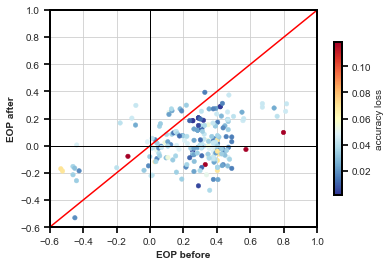

In [73]:
plt.scatter(xs, ys, c =acs, linewidths = .5, marker ="o", cmap="RdYlBu_r", s=20)
plt.xlabel("EOP before", fontweight="bold")
plt.ylabel("EOP after", fontweight="bold")
plt.xlim([-.6, 1])
plt.ylim([-.6, 1])
plt.axline((0, 0), (1, 1), linewidth=1.5, color='r')
plt.axline((0, 0), (0, 1), linewidth=1, color='black')
plt.axline((0, 0), (1, 0), linewidth=1, color='black')
plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)
#plt.clim(-.1,.1)
#plt.savefig('fig1.pdf', bbox_inches='tight', dpi=400)
plt.show()

In [52]:
y_pred_c = encoders['class'].transform(census_test_c['pred_c'])
summary_c = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_c,
                          sensitive_features=X_test['RAC1P'])
summary_c.overall-summary_c.by_group

RAC1P
0.0    0.023483
1.0   -0.002742
2.0   -0.001907
3.0     0.00102
4.0    0.000376
5.0   -0.009455
6.0     0.00375
7.0    0.005641
8.0   -0.000317
Name: true_positive_rate, dtype: object

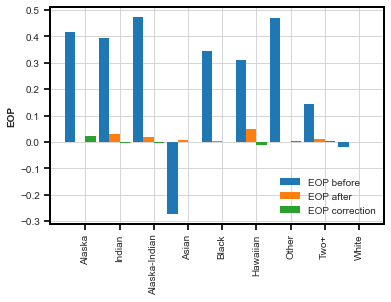

In [53]:
X_axis = np.arange(len(pretty_rac1p))
plt.bar(X_axis - 0.45, summary_b.overall-summary_b.by_group, 0.3, label='EOP before')
plt.bar(X_axis - 0.15, summary_a.overall-summary_a.by_group, 0.3, label='EOP after')
plt.bar(X_axis + 0.15, summary_c.overall-summary_c.by_group, 0.3, label='EOP correction')
plt.xticks(X_axis, pretty_rac1p)
plt.xticks(rotation=90)
plt.legend(loc=4)
plt.ylabel("EOP", fontweight="bold")
#plt.savefig('fig0.pdf', bbox_inches='tight', dpi=400)
plt.show()

In [54]:
y_pred_bt = clf.predict(X_train)
census_train['pred_bt'] = encoders['class'].inverse_transform(y_pred_bt)
disc_bt = dd.DD(census_train[disc_all+['pred_bt']], unprotectedItem='RAC1P=White alone', 
               predBadItem='pred_bt=False', trueBadItem='class=False',
               codes=disc_b.codes) # extends the coding of items as disc_a 

In [55]:
# To compute P(pred.good|true.good) we need the dd.DD object
metric_bt = lambda ctg: eop_mean(ctg, disc_bt)

In [56]:
# Extract contingency tables: 
ctgs_bt = disc_bt.extract(testCond=metric_bt, minSupp=-50, topk=10000)

In [57]:
# sequential covering algorithm: 10 contingency tables
covers, residuals, times, uncovered, ctg_cov, ctg_uncov = disc_bt.cover_n([ctg for _,ctg in ctgs_bt], metric_bt, 100)
print('Total protected:', sum(residuals)+len(uncovered))
print('Total protected covered:', sum(residuals))
print('% covered: {:.2f}%'.format(100*sum(residuals)/(sum(residuals)+len(uncovered))))
# OR's of covering contexts and any protected
#disc_bt.print(ctg_cov)
#print("Metric = {:f}".format(metric_bt(ctg_cov)))

Total protected: 245489
Total protected covered: 30032
% covered: 12.23%


In [58]:
# Cover contingency tables
sum_rd = cnt_rd = i = 0
for ctg, res in zip(covers, residuals):
    print('-----\nCT', i, 'covered', res)
    i += 1
    disc_bt.print(ctg)
    print("Metric = {:f}".format(metric_bt(ctg)))
    sum_rd += metric_bt(ctg)*ctg.n1()
    cnt_rd += ctg.n1()
print('-----\nAverage metric = {:f}'.format(sum_rd/cnt_rd))

-----
CT 0 covered 118
-----
Context STATE=MD AND WKHPgroup=>40
Size = 5613  Perc = 0.50%
RAC1P=Some Other Race alone                     RAC1P=White alone
           |pred_bt=False|pred_bt=True|                    |pred_bt=False|pred_bt=True|    
class=False|           73|           0|  73     class=False|           18|        1016|1034
class=True |           45|           0|  45     class=True |            3|        3074|3077
           |          118|           0| 118                |         4090|          21|4111
Metric = 0.983944
-----
CT 1 covered 246
-----
Context STATE=NJ AND WKHPgroup=>40
Size = 8150  Perc = 0.73%
RAC1P=Some Other Race alone                     RAC1P=White alone
           |pred_bt=False|pred_bt=True|                    |pred_bt=False|pred_bt=True|    
class=False|          156|           0| 156     class=False|            6|        1529|1535
class=True |           90|           0|  90     class=True |            0|        4989|4989
           |          246|

In [59]:
# switch to test set
all_covered = disc_b.itDB.cover_none()
for c in covers:
    all_covered |= disc_b.itDB.cover(c.ctx)

In [60]:
len(all_covered)

190787

In [61]:
# selected = all - covered
sel = list(set(range(len(census_test)))-set(all_covered))
census_test_r = census_test.iloc[sel,:]
print('Coverage', len(sel)/len(census_test))

Coverage 0.6526630073641189


In [62]:
disc_r = dd.DD(census_test_r[disc_all+['pred_b']], unprotectedItem='RAC1P=White alone', 
               predBadItem='pred_b=False', trueBadItem='class=False', 
               codes=disc_b.codes) # extends the coding of items as disc_a 

In [63]:
# To compute P(pred.good|true.good) we need the dd.DD object
metric_r = lambda ctg: eop_mean(ctg, disc_r)

In [64]:
# each protected vs unprotected
for ctg in disc_r.ctg_global():
    disc_r.print(ctg)
    print("Metric = {:f}".format(metric_r(ctg)))

-----
Context ALL
Size = 358498  Perc = 100.00%
RAC1P=Black or African American alone           RAC1P=White alone
           |pred_b=False|pred_b=True|                      |pred_b=False|pred_b=True|      
class=False|       27458|          0| 27458     class=False|      196430|         38|196468
class=True |        6257|          0|  6257     class=True |       77555|         41| 77596
           |       33715|          0| 33715                |          79|     273985|274064
Metric = 0.055581
-----
Context ALL
Size = 358498  Perc = 100.00%
RAC1P=Two or More Races                        RAC1P=White alone
           |pred_b=False|pred_b=True|                      |pred_b=False|pred_b=True|      
class=False|        7413|          5|  7418     class=False|      196430|         38|196468
class=True |        2015|          2|  2017     class=True |       77555|         41| 77596
           |        9428|          7|  9435                |          79|     273985|274064
Metric = 0.054590
-

In [78]:
xs, ys, descs, acs = data_plot(disc_b, metric_b, disc_r, metric_r)

C:\Users\ruggieri\AppData\Local\Temp\ipykernel_19000\2474141951.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)


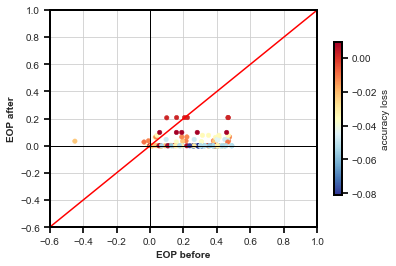

In [79]:
plt.scatter(xs, ys, c =acs, linewidths = .5, marker ="o", cmap="RdYlBu_r", s=20)
plt.xlabel("EOP before", fontweight="bold")
plt.ylabel("EOP after", fontweight="bold")
plt.xlim([-.6, 1])
plt.ylim([-.6, 1])
plt.axline((0, 0), (1, 1), linewidth=1.5, color='r')
plt.axline((0, 0), (0, 1), linewidth=1, color='black')
plt.axline((0, 0), (1, 0), linewidth=1, color='black')
plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)
#plt.clim(-.1,.1)
#plt.savefig('fig1.pdf', bbox_inches='tight', dpi=400)
plt.show()

In [67]:
y_pred_r = encoders['class'].transform(census_test_r['pred_b'])
y_test_r = encoders['class'].transform(census_test_r['class'])
X_test_r = X_test.iloc[sel,:]
summary_r = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test_r,
                          y_pred=y_pred_r,
                          sensitive_features=X_test_r['RAC1P'])
summary_r.overall-summary_r.by_group

RAC1P
0.0    0.055581
1.0    0.055581
2.0    0.055581
3.0   -0.579823
4.0    0.055581
5.0    0.055581
6.0    0.055581
7.0     0.05459
8.0    0.055053
Name: true_positive_rate, dtype: object

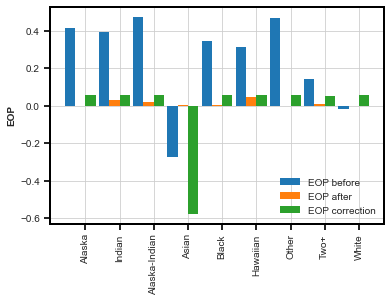

In [68]:
X_axis = np.arange(len(pretty_rac1p))
plt.bar(X_axis - 0.45, summary_b.overall-summary_b.by_group, 0.3, label='EOP before')
plt.bar(X_axis - 0.15, summary_a.overall-summary_a.by_group, 0.3, label='EOP after')
plt.bar(X_axis + 0.15, summary_r.overall-summary_r.by_group, 0.3, label='EOP correction')
plt.xticks(X_axis, pretty_rac1p)
plt.xticks(rotation=90)
plt.legend(loc=4)
plt.ylabel("EOP", fontweight="bold")
#plt.savefig('fig0.pdf', bbox_inches='tight', dpi=400)
plt.show()